# IMPORT LIBRARIES USED

In [7]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
tf.debugging.set_log_device_placement(False)

# SPECIFY THE PATH USED

## *Path to current directory*

In [9]:
full_path = os.path.abspath('')
full_path

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main'

## *Path to dataset*

In [10]:
dataset = os.path.join(full_path, 'model/point_history_classifier/point_history.csv')
dataset = os.path.normpath(dataset)
dataset

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main\\model\\point_history_classifier\\point_history.csv'

## *Path to where the model is saved*

In [11]:
model_save_path = os.path.join(full_path, 'model/point_history_classifier/point_history_classifier_with_threshold1.keras')
model_save_path = os.path.normpath(model_save_path)
model_save_path

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main\\model\\point_history_classifier\\point_history_classifier_with_threshold.keras'

## *Path to the folder where the model is saved*

In [12]:
saved_model_path = os.path.join(full_path, 'model/point_history_classifier')
saved_model_path = os.path.normpath(saved_model_path)
saved_model_path

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main\\model\\point_history_classifier'

## *Path to TfLite model*

In [13]:
tflite_save_path = os.path.join(full_path, 'model/point_history_classifier/point_history_classifier_with_threshold1.tflite')
tflite_save_path = os.path.normpath(tflite_save_path)
tflite_save_path

'e:\\Games\\UnityProject\\HandDetection\\hand-gesture-recognition-using-mediapipe-main\\model\\point_history_classifier\\point_history_classifier_with_threshold.tflite'

# SET PARAMETERS

## *Classification number*

In [14]:
NUM_CLASSES = 5

## *Input length*

In [15]:
TIME_STEPS = 16
DIMENSION = 2

# LOAD DATA FOR LEARNING

## *Load data without dependency*

In [16]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

## *Load dependent data (**Label**)*

In [17]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

### *Value for random state*

In [18]:
RANDOM_SEED = 42

### *Splitting the dataset*

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [21]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 231, 1: 230, 2: 224, 3: 218, 4: 229}

In [20]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 691, 1: 670, 2: 676, 3: 685, 4: 674}

# CONFIGURE THE LEARNING MODEL

## *Set up model structure*

### *Set parameters to configure the model*

#### *Parameter indicating whether LTSM (Long Short Term Memory) is used in the model*

In [14]:
use_lstm = True

#### *Parameter refer to the model*

In [15]:
model = None

### *Model configurating*

* Model structure using LSTM:
> 1. Input Layer
> 2. Reshape Layer ((32) -> (16, 2))
> 3. Dropout Layer (0.2)
> 4. LSTM Layer
> 5. Dropout Layer (0.5)
> 6. Fully-connected-10 with ReLU as activation
> 7. Fully-connected-5 with SoftMax as activation
* Model structure without using LSTM:
> 1. Input Layer
> 2. Dropout Layer (0.2)
> 3. Fully-connected-24 with ReLU as activation
> 4. Dropout Layer (0.5)
> 5. Fully-connected-10 with ReLU as activation
> 6. Fully-connected-5 with SoftMax as activation

In [16]:
if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.name = "Hand_Gesture_Regconize_Using_LTSM_Model"
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.name = "Hand_Gesture_Regconize_Model1"

c:\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## *Model summary*

### *Table*

In [17]:
model.summary()  

Model: "Hand_Gesture_Regconize_Using_LTSM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 16, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,441 (5.63 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

### *Graph*

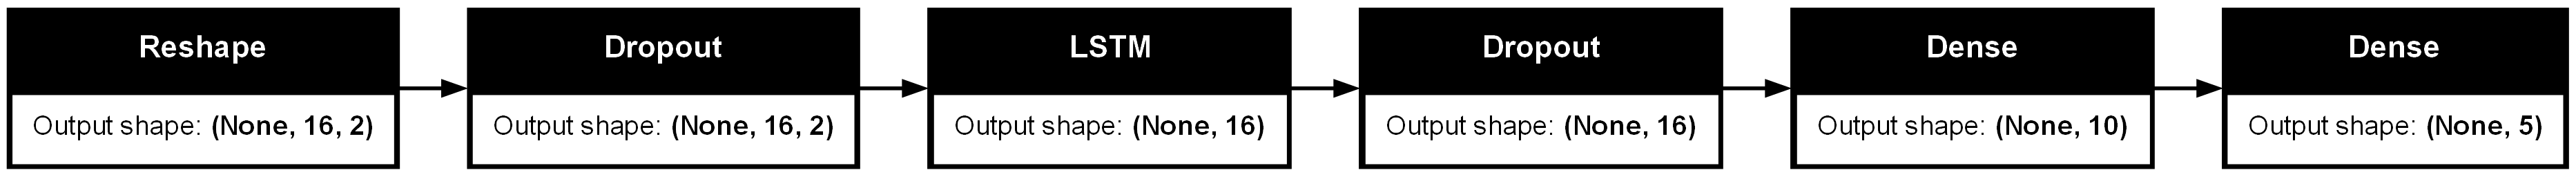

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file="graph/IndexFingerGestureWithThresholdModelStructure1.png", rankdir='LR')

## *Set up callbacks for the model*

### *Model checkpoint callback*

In [19]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

### *Model early stopping callback*

In [20]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

## *Model compilation*

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# MODEL TRAINING

In [22]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3127 - loss: 1.5892
Epoch 1: saving model to e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\point_history_classifier_with_threshold.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3145 - loss: 1.5888 - val_accuracy: 0.5910 - val_loss: 1.5424
Epoch 2/1000
16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5088 - loss: 1.5300 
Epoch 2: saving model to e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\point_history_classifier_with_threshold.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5200 - loss: 1.5203 - val_accuracy: 0.7491 - val_loss: 1.4293
Epoch 3/1000
16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 1.4038 
Epoch 3: saving model to e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\poi

# MODEL EVALUATION

## *Evaluate validation results*

In [23]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0732 


## *Prediction test*

### *Loading a saved model*

In [24]:
model = tf.keras.models.load_model(model_save_path)

### *Prediction testing*

In [25]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
[1.7012645e-06 2.3702796e-05 9.9995518e-01 1.6803422e-05 2.6483731e-06]
2


# CONFUSION MATRIX

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


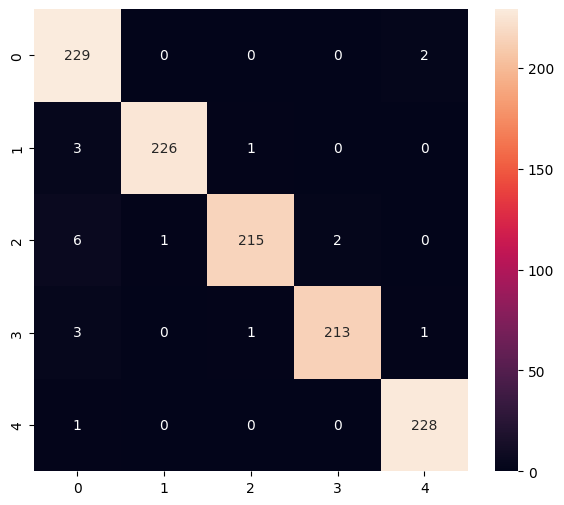

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       231
           1       1.00      0.98      0.99       230
           2       0.99      0.96      0.98       224
           3       0.99      0.98      0.98       218
           4       0.99      1.00      0.99       229

    accuracy                           0.98      1132
   macro avg       0.98      0.98      0.98      1132
weighted avg       0.98      0.98      0.98      1132



In [26]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.savefig("graph/IndexFingerGestureWithThresholdModelConfusionMatrix1.png")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# TRAINING HISTORY OF THE MODEL

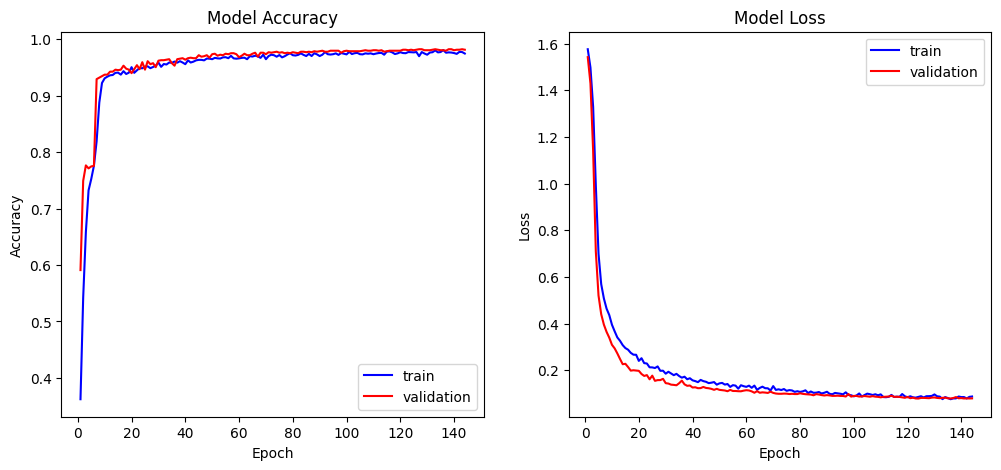

In [27]:
def plot_history(history):
    acc = history.history["accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    val_accuracy = history.history["val_accuracy"]
    
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="train")
    plt.plot(x, val_accuracy, "r", label="validation")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="train")
    plt.plot(x, val_loss, "r", label="validation")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.savefig("graph/IndexFingerGestureWithThresholdModelTrainingHistory1.png")
    
plot_history(history)

# MODEL CONVERTING FOR TensorFlow-Lite

## *Model export*

In [28]:
# model.save(model_save_path, include_optimizer=False)
model.export(filepath=saved_model_path, format="tf_saved_model")

INFO:tensorflow:Assets written to: e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\assets


INFO:tensorflow:Assets written to: e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier\assets


Saved artifact at 'e:\Games\UnityProject\HandDetection\hand-gesture-recognition-using-mediapipe-main\model\point_history_classifier'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1746092930352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746092931056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746092928064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746092929120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746092928944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746117482576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746117485920: TensorSpec(shape=(), dtype=tf.resource, name=None)


## *Load the exported model*

In [29]:
model = tf.keras.models.load_model(model_save_path)

## *Transform the model (**quantize**)*

In [30]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)  
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

16472

# REASONING TEST

## *Set up an interpreter*

In [31]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

## *Get input tensor*

In [32]:
input_details = interpreter.get_input_details()

## *Get output tensor*

In [33]:
output_details = interpreter.get_output_details()

## *Set the value for the input tensor*

In [34]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

## *Inference implementation*

In [35]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


## *Print the results*

In [36]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.6365473e-06 2.3290604e-05 9.9995601e-01 1.6465579e-05 2.5926270e-06]
2


In [6]:
rows, cols = (21, 2)
arr = [[0]*cols]*rows
arr

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0]]